# An overview of GluonTS

### Opensource python toolkit based on Apache MXNet and Gluon

- Implementations of state of the art models
- Baseline models
- Tools for model evaluation and comparison
- Dataloaders and iterators

### Models:
- DeepAR
- Deep factor
- DeepState
- Wavenet
- Transformer models 
- Seq-2-seq models
- etc.

## Components of GluonTS

### The Estimator and the Predictor
- An **Estimator** represents a model that can be trained on a dataset to yield a
- a **Predictor**, which can later be used to make predictions on unseen data.


```python
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

estimator = DeepAREstimator(freq="5min", 
                            prediction_length=36, 
                            trainer=Trainer(epochs=10))
```

```python
from gluonts.model.deepar import DeepAREstimator 
```
- `DeepArEstimator` is an abstraction for models. 
- Other supported estimators include:
 - Seq2SeqEstimator
 - CanonicalRNNEstimator
 - SimpleFeedForwardEstimator
 - WaveNetEstimator

### Dataset
- **Dataset** abstraction for providing uniform access to data across different input formats
- In GluonTS, any Dataset is just an Iterable over dictionaries mapping string keys to arbitrary values
- There are two variations of dataset: **FileDataSet** and **ListDataset**
- In order to implement your own dataset:
  - you will need to derive a class from `gluonts.dataset.common.Dataset`, and
  - implement `__iter__`, and `__len__`
  - more information can be found [here](https://github.com/awslabs/gluon-ts/blob/master/src/gluonts/dataset/common.py).


### Dataset

```python
from gluonts.dataset.common import ListDataset

training_data = ListDataset(
    [{"start": df.index[0], "target": df.value[:"2015-04-05 00:00:00"]}],
    freq = "5min"
)
```

- A dataset object requires start and target (pandas timestamp)
- Please note that your data does not require to have a timestamp field but should be aggregated as ***fixed-length intervals***.
- You shall need to pass a frequency parameter, which is compatible with pandas frequency.
- **ListDataset** to access data stored in memory as a list of dictionaries.

### Predictor
- you can call your estimator's **train** methods to kick-off training.
- train will return a **predictor** object after completes the training.
- You can then use the predictor object in order to make inference.

```python
predictor = estimator.train(training_data)
```

### Evaluation
- You can use the predictor in order to create a forecast:


```python
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    test_data, 
    predictor, 
    num_eval_samples=100)
forecasts = list(forecast_it)
tss = list(ts_it)
```

```python
def plot_forecasts(tss, forecasts, past_length):
    for target, forecast in islice(zip(tss, forecasts)):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()
```

### Plotting the forecast
- Plotting the forecast gives you a qualitative feel for the model output.

```python
plot_forecasts(tss, forecasts, past_length=150, num_plots=3)
```
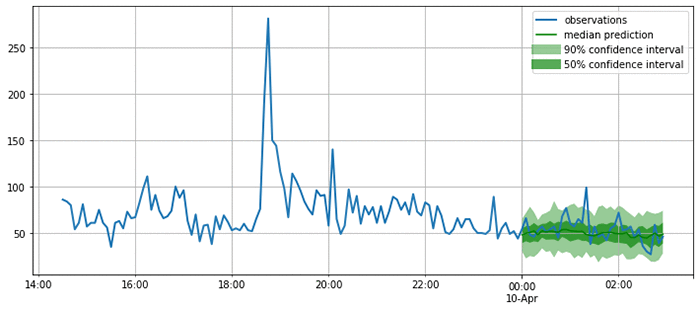

### Evaluator class
- **Evaluator** provides a multi-metric quantitative evaluation of the model.

```python
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.5], seasonality=1)
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))
```

```python
agg_metrics

{'MSE': 163.59102376302084,
 'abs_error': 1090.9220886230469,
 'abs_target_sum': 5658.0,
 'abs_target_mean': 52.38888888888889,
 'seasonal_error': 18.833625618877182,
 'MASE': 0.5361500323952336,
 'sMAPE': 0.21201368270827592,
 'MSIS': 21.446000940010823,
 'QuantileLoss[0.5]': 1090.9221000671387,
 'Coverage[0.5]': 0.34259259259259256,
 'RMSE': 12.790270668090681,
 'NRMSE': 0.24414090352665138,
 'ND': 0.19281054942082837,
 'wQuantileLoss[0.5]': 0.19281055144346743,
 'mean_wQuantileLoss': 0.19281055144346743,
 'MAE_Coverage': 0.15740740740740744}
```